In [22]:
import numpy as np
from matplotlib import pyplot as plt
import mne, os
import json

# Load the JSON data from the file
with open('C:\\Users\\matil\\Desktop\\FYP\\code_env\\eeg-notebooks\\FYP\\results_data\\Outliers_7030.json', 'r') as file:
    data = json.load(file)

# Create an empty list to store the key names
keys_below_30 = []

# Iterate through the keys and check if all values are below 30
for key, values in data.items():
    if all(value < 50 for value in values):
        key = key.replace('.json', '.fif')
        keys_below_30.append(key)

to_add = ['VibroVisual_10_2.fif','VibroVisual_02_2.fif','VibroVisual_03_1.fif','VibroVisual_03_2.fif']
for i in to_add:
    keys_below_30.append(i)
# Print the list of key names
print(keys_below_30)


['AudioVisual_04_1.fif', 'AudioVisual_04_2.fif', 'AudioVisual_06_1.fif', 'AudioVisual_06_2.fif', 'ShapeVisual_01_1.fif', 'ShapeVisual_01_2.fif', 'ShapeVisual_02_2.fif', 'ShapeVisual_03_1.fif', 'ShapeVisual_03_2.fif', 'ShapeVisual_04_1.fif', 'ShapeVisual_04_2.fif', 'ShapeVisual_06_2.fif', 'ShapeVisual_07_2.fif', 'ShapeVisual_09_1.fif', 'ShapeVisual_10_1.fif', 'ShapeVisual_10_2.fif', 'ShapeVisual_11_1.fif', 'ShapeVisual_11_2.fif', 'VibroVisual_06_1.fif', 'VibroVisual_10_2.fif', 'VibroVisual_02_2.fif', 'VibroVisual_03_1.fif', 'VibroVisual_03_2.fif']


In [49]:
raw_folder = os.path.join(os.path.expanduser('~/'), 'Desktop', 'FYP', 'code_env', 'eeg-notebooks', 'FYP', 'data_ordered', 'mne_raw')
raw_files = [file for file in keys_below_30]

psd_data = {
    'Audio': [],
    'Vibro': [],
    'Shape': []
}

for file in raw_files:
    print("Computing PSD analysis for trial", file)
    raw_path = os.path.join(raw_folder, file)
    raw = mne.io.read_raw_fif(raw_path, preload=True)
    data = raw.get_data()

    # Determine the modality based on the file name
    if 'Audio' in file:
        modality = 'Audio'
    elif 'Vibro' in file:
        modality = 'Vibro'
    elif 'Shape' in file:
        modality = 'Shape'
    else:
        continue

    # Compute the power spectrum for each channel
    psd_array = []
    for ch in range(data.shape[0]):
        psd, freqs = mne.time_frequency.psd_array_welch(data[ch], sfreq=raw.info['sfreq'])
        psd_array.append(psd)

    psd_data[modality].append(psd_array)


Computing PSD analysis for trial AudioVisual_04_1.fif
Computing PSD analysis for trial AudioVisual_04_2.fif
Computing PSD analysis for trial AudioVisual_06_1.fif
Computing PSD analysis for trial AudioVisual_06_2.fif
Computing PSD analysis for trial ShapeVisual_01_1.fif
Computing PSD analysis for trial ShapeVisual_01_2.fif
Computing PSD analysis for trial ShapeVisual_02_2.fif
Computing PSD analysis for trial ShapeVisual_03_1.fif
Computing PSD analysis for trial ShapeVisual_03_2.fif
Computing PSD analysis for trial ShapeVisual_04_1.fif
Computing PSD analysis for trial ShapeVisual_04_2.fif
Computing PSD analysis for trial ShapeVisual_06_2.fif
Computing PSD analysis for trial ShapeVisual_07_2.fif
Computing PSD analysis for trial ShapeVisual_09_1.fif
Computing PSD analysis for trial ShapeVisual_10_1.fif
Computing PSD analysis for trial ShapeVisual_10_2.fif
Computing PSD analysis for trial ShapeVisual_11_1.fif
Computing PSD analysis for trial ShapeVisual_11_2.fif
Computing PSD analysis for t

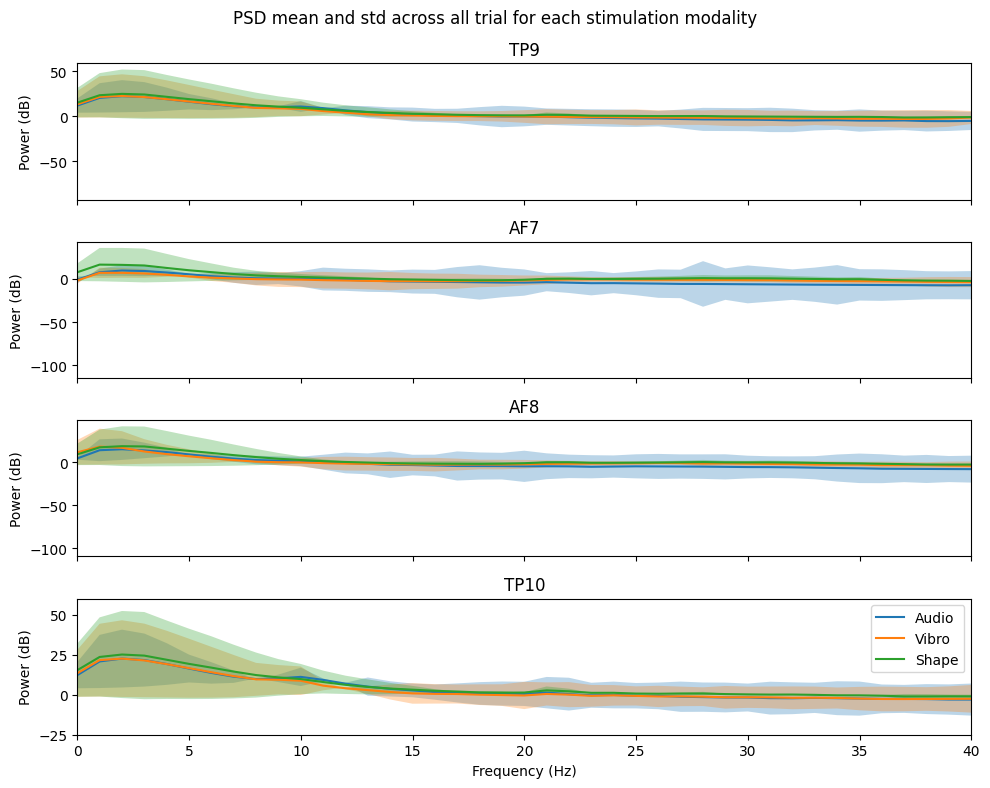

PSD data saved to 'psd_data.npy'


In [55]:

fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
channel_names = ['TP9', 'AF7', 'AF8', 'TP10']

# Plotting mean and std for each modality and channel
for modality in psd_data.keys():
    psd_array = np.array(psd_data[modality])
    mean_psd = 10*np.log10(np.mean(psd_array, axis=0))
    std_psd = 10*np.log10(np.std(psd_array, axis=0))

    for ch in range(mean_psd.shape[0]):
        axs[ch].plot(freqs, mean_psd[ch], label=f'{modality}')
        axs[ch].fill_between(freqs, mean_psd[ch] - std_psd[ch], mean_psd[ch] + std_psd[ch], alpha=0.3)
        axs[ch].set_xlim(-25, 60)

# Set titles and labels for each subplot
for i, ax in enumerate(axs):
    ax.set_title(f'{channel_names[i]}')
    ax.set_ylabel('Power (dB)')
    axs[ch].set_xlim(-25, 60)

plt.xlim(0, 40) 
plt.ylim(-25, 60)
ax.legend()

axs[-1].set_xlabel('Frequency (Hz)')
plt.suptitle("PSD mean and std across all trial for each stimulation modality")
plt.tight_layout()
 
plt.show()

# Save the PSD data dictionary to a file
np.save('psd_data.npy', psd_data)
print("PSD data saved to 'psd_data.npy'")


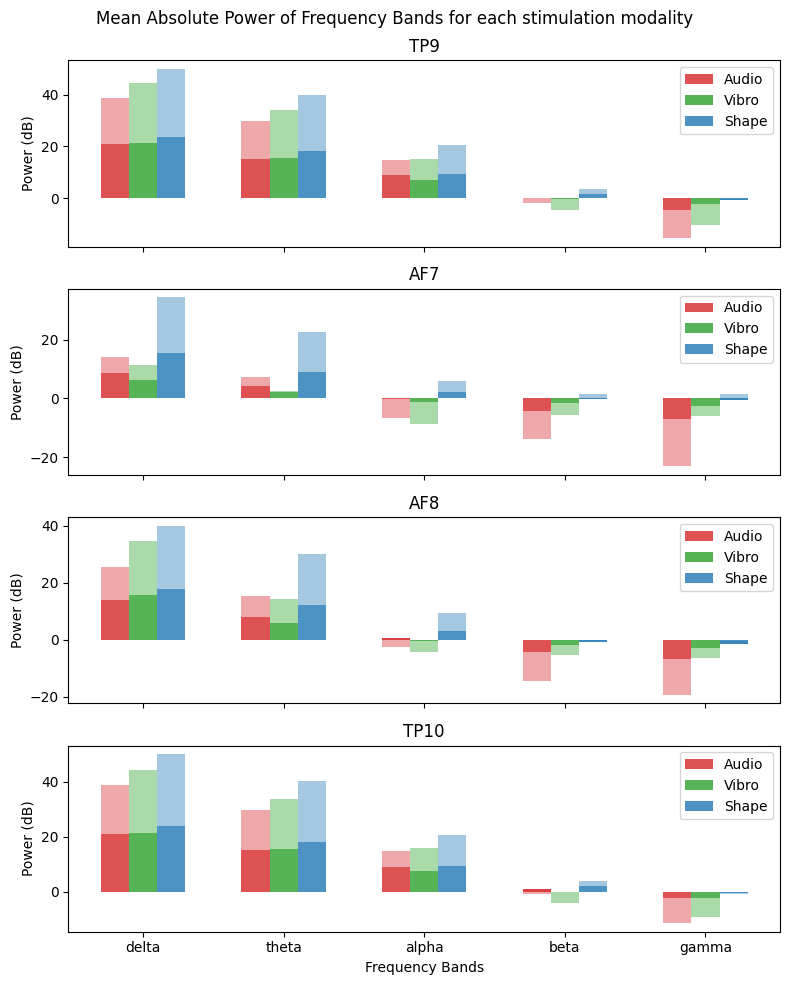

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Load the PSD data from the previously saved file
psd_data = np.load('psd_data.npy', allow_pickle=True).item()

# Define the frequency bands of interest
bands = {'delta': (0.1, 4),
         'theta': (4, 8),
         'alpha': (8, 13),
         'beta': (13, 30),
         'gamma': (30, 40)}

# Initialize arrays to store the absolute and relative power for each channel and modality
abs_power = {modality: np.zeros((len(bands), len(psd_data[modality][0]))) for modality in psd_data.keys()}
rel_power = {modality: np.zeros((len(bands), len(psd_data[modality][0]))) for modality in psd_data.keys()}
abs_power_std = {modality: np.zeros((len(bands), len(psd_data[modality][0]))) for modality in psd_data.keys()}
rel_power_std = {modality: np.zeros((len(bands), len(psd_data[modality][0]))) for modality in psd_data.keys()}
# Convert psd_data from list to numpy array
psd_data = {modality: np.array(data) for modality, data in psd_data.items()}

# Compute the absolute and relative power for each frequency band and each channel and modality
for modality, psd_array in psd_data.items():
    for ch in range(len(psd_array[0])):
        for i, (fmin, fmax) in enumerate(bands.values()):
            freq_indices = np.where((freqs >= fmin) & (freqs <= fmax))[0]
            band_psd = psd_array[:, ch, freq_indices]
            abs_power[modality][i, ch] = np.mean(band_psd)
            rel_power[modality][i, ch] = np.mean(band_psd) / np.sum(psd_array[:, ch])
            abs_power_std[modality][i, ch] = np.std(band_psd)
            rel_power_std[modality][i, ch] = np.std(band_psd) / np.sum(psd_array[:, ch])

# Plotting the mean and standard deviation of each channel as a bar chart
fig, axs = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

freq_labels = list(bands.keys())
x = np.arange(len(freq_labels))
bar_width = 0.2
opacity = 0.8
opacity_std = 0.4
colors = [ 'tab:red', 'tab:green', 'tab:blue']
channel_names = ['TP9', 'AF7', 'AF8', 'TP10']

for ch in range(len(psd_data['Audio'][0])):
    for i, modality in enumerate(psd_data.keys()):
        mean_power = 10*np.log10(abs_power[modality][:, ch]) # Change here for relative power
        std_power = 10*np.log10(abs_power_std[modality][:, ch]) # Change here for relative power

        axs[ch].bar(x + i * bar_width, mean_power, bar_width, alpha=opacity, color=colors[i],
                    label=modality) #, yerr=std_power)
        axs[ch].bar(x + i * bar_width, std_power, width=bar_width, align='center', bottom=mean_power,
        alpha=opacity_std, color=colors[i])

    axs[ch].set_ylabel('Power (dB)')
    axs[ch].set_xticks(x + bar_width * (len(psd_data.keys()) - 1) / 2)
    axs[ch].set_xticklabels(freq_labels)
    axs[ch].set_title(f'{channel_names[ch]}')
    axs[ch].legend()
plt.suptitle("Mean Relative Power of Frequency Bands for each stimulation modality")
plt.xlabel('Frequency Bands')
plt.tight_layout()
plt.show()
